In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
from bluesunb.preprocessing.stock_preprocessing import load_data_with_preprocessing

options = {
    'seq_len': 128,
    'pred_len': 7,
    'using_cols': ['open', 'high', 'low', 'close', 'vol'],
}
file_path = os.path.abspath('../data/samsung-stock-data-2000-2021.csv')
(X_train, y_train), (X_valid, y_valid), (X_test, y_test), df = \
    load_data_with_preprocessing(file_path, options)

# Time Embedding

In [3]:
from tensorflow.python.keras.layers import Layer
time_cols_num = 4
print(df.columns[:time_cols_num])
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                               shape=(int(self.seq_len),),
                                               initializer='uniform',
                                               trainable=True)

    def call(self, inputs, *args, **kwargs):
        x = tf.math.reduce_mean(inputs[:,:,:time_cols_num], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)  #(N, seq_len, 1)

        time_periodc = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodc = tf.expand_dims(time_periodc, axis=-1)
        return tf.concat([time_linear, time_periodc], axis=-1)  #(N, seq_len, 2)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

Index(['open', 'high', 'low', 'close'], dtype='object')


# Attention

In [4]:
from tensorflow.python.keras.layers import Dense

class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           name='query_linear',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         name='key_linear',
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           name='value_linear',
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])   # (in_seq, d_k)
        k = self.key(inputs[1])     # (in_seq, d_k)
        v = self.value(inputs[2])   # (in_seq, d_v)

        attn_weights = tf.matmul(q, k, transpose_b=True)    # (in_seq, in_seq)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1) # (in_seq, in_seq)

        attn_out = tf.matmul(attn_weights, v)   # (in_seq, d_v)
        return attn_out


class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = []


    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
        self.linear = Dense(input_shape[0][-1],
                            name='multi_attn_linear',
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs, *args, **kwargs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)  # (in_seq, 3*d_v)
        multi_linear = self.linear(concat_attn) # (in_seq, input_shape[0][-1])
        return multi_linear

# Transformer

In [5]:
from tensorflow.python.keras.layers import Dropout, LayerNormalization, Conv1D

class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = []
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate, name='attn_dropout')
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6, name='attn_ln')

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu', name='ff_conv1D_1')
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1, name='ff_conv1D_2')
        self.ff_dropout = Dropout(self.dropout_rate, name='ff_dropout')
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6, name='ff_ln')

    def call(self, inputs, *args, **kwargs):
        attn_layer = self.attn_multi(inputs)    # (in_seq, in_seq)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'attn_heads': self.attn_heads,
                       'ff_dim': self.ff_dim,
                       'dropout_rate': self.dropout_rate})
        return config

# Model

In [6]:
seq_len = options['seq_len']
pred_len = options['pred_len']
d_k = int(256*5/8)
d_v = int(256*5/8)
batch_size = 24
n_heads = 12
ff_dim = int(256*5/8)

In [7]:
from tensorflow.python.keras.layers import Input, GlobalAveragePooling1D, Concatenate
from tensorflow.python.keras.models import Model
def create_model(col_len):
    time_embedding = Time2Vector(seq_len=seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    in_seq = Input(shape=(seq_len, col_len))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])

    x = attn_layer1((x,x,x))
    x = attn_layer2((x,x,x))
    x = attn_layer3((x,x,x))

    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(pred_len, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

model = create_model(X_train.shape[-1])

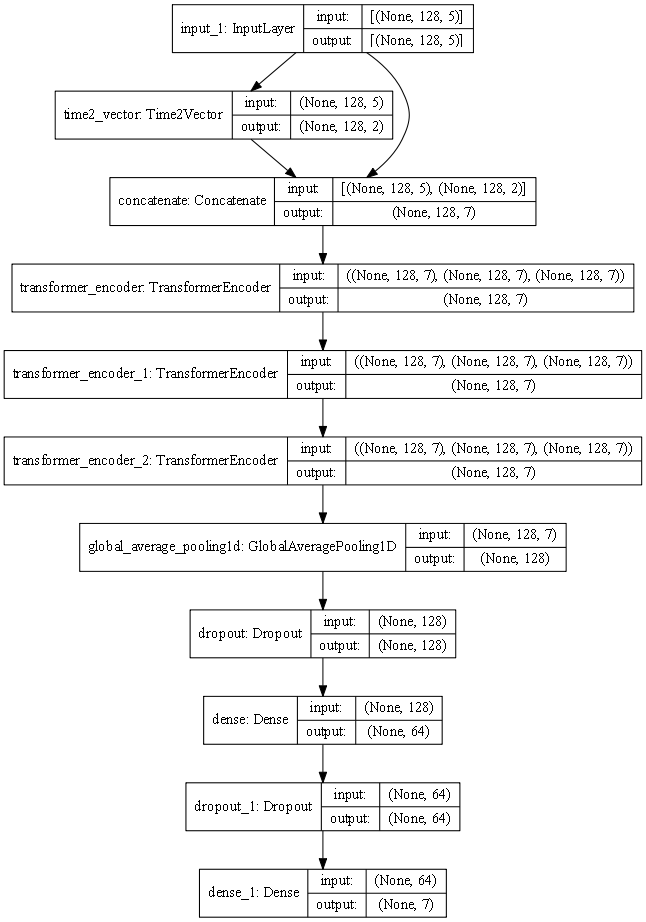

In [8]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True, dpi=75)

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('Tf+Te.hdf5', monitor='val_loss', save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=40, callbacks=[mc],
                    validation_data=(X_valid, y_valid))

## Evaluation

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_valid, y_valid, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [ ]:
def list_plot_pred(pred):
    """
    If pred_len > 1, the result prediction data is mean on non-zeros of overlapped
    """
    if pred.shape[1]==1:
        return pred

    plot_pred = np.zeros((len(pred), len(pred)))
    for i in range(len(pred)):
        plot_pred[i] = np.pad(pred[i], [i, len(pred)-i-pred.shape[1]])

    nonzero = np.count_nonzero(plot_pred, axis=0)
    plot_pred = np.sum(plot_pred, axis=0)/nonzero
    return plot_pred

train_pred = list_plot_pred(train_pred)
val_pred = list_plot_pred(val_pred)
test_pred = list_plot_pred(test_pred)

In [ ]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_valid, label='IBM Closing Returns')
# ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.plot(np.arange(len(val_pred)), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test, label='IBM Closing Returns')
# ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.plot(np.arange(len(test_pred)), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Teacher Forcing

In [ ]:
def make_validation(data):
  data = data.copy()
  pred = data[0, :, 3].tolist()
  for i in range(0, len(data), pred_len):
    X = data[i]
    X[:, 3] = pred[-seq_len:]
    output = model.predict(X[None,:,:]).flatten().tolist()
    pred.extend(output)
  return pred[seq_len:]

In [ ]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_valid, label='IBM Closing Returns')
# ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.plot(np.arange(len(val_pred[seq_len:])), val_pred[seq_len:], linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test, label='IBM Closing Returns')
# ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.plot(np.arange(len(test_pred[seq_len:])), test_pred[seq_len:], linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)